In [133]:
import pandas as pd
import numpy as np
import sqlalchemy as sa
import datetime as dt
import os
from dotenv import load_dotenv
load_dotenv()
import warnings
warnings.filterwarnings('ignore')

engine = sa.create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}"
    .format(host=os.getenv('host'), db=os.getenv('db'), user=os.getenv('uname'), pw=os.getenv('password')))

## Make Prime table in DB

In [228]:
df = pd.read_csv("prime.csv")
df['DATE'] = pd.to_datetime(df['DATE'])

df.to_sql(name="prime_rates", con= engine, if_exists='replace', index=False)

query_mod_date_col = """ALTER TABLE `sba`.`prime_rates` 
CHANGE COLUMN `DATE` `DATE` DATE NOT NULL ,
ADD UNIQUE INDEX `DATE_UNIQUE` (`DATE` ASC);
;"""

engine.execute(query_mod_date_col)

# query to add date and year columns for easier joins
add_mth_year_queries = []
add_mth_year_queries.append(sa.text("ALTER TABLE prime_rates ADD COLUMN p_MONTH int NULL AFTER date ;"))
add_mth_year_queries.append(sa.text("ALTER TABLE prime_rates ADD COLUMN p_YEAR int NULL AFTER date ;"))
add_mth_year_queries.append(sa.text("UPDATE prime_rates SET prime_rates.p_MONTH = MONTH(prime_rates.`DATE`);"))
add_mth_year_queries.append(sa.text("UPDATE prime_rates SET prime_rates.p_YEAR = YEAR(prime_rates.`DATE`);"))

                # INSERT INTO prime_rates(month) FROM prime_rates;
for q in add_mth_year_queries:
    engine.execute(q)

prime_df = pd.read_sql("SELECT * FROM sba.prime_rates",engine)

## Read in loan data, format dates

In [229]:
loan_df = pd.read_sql('SELECT * FROM clean_version', con=engine)
date_cols = [c for c in loan_df.columns if 'Dt' in c]
for c in date_cols:
    loan_df[c] = pd.to_datetime(loan_df[c])
loan_df['Note_Yr'] = loan_df['NoteDt'].dt.year
loan_df['Note_Mth'] = loan_df['NoteDt'].dt.month
first_cols = ['GP','Note_Yr','Note_Mth'] 
formatted_order = first_cols + [c for c in loan_df.columns if c not in first_cols]
loan_df = loan_df[formatted_order] 
loan_df.head()

,GP,Note_Yr,Note_Mth,NoteDt,LoanAmt,MaturityDt,MaturityMthsQty,PrepayDt,PrepayMthsQty,DefaultDt,DefaultMthsQty,MatBucket
0,1502649,2000,7,2000-07-31,20600.00,2007-07-31,84,2008-10-08,NaN,2006-03-06,67.0,0-8
1,1503079,2001,1,2001-01-31,14288.55,2008-01-31,84,2010-11-30,NaN,2004-03-02,37.0,0-8
2,2019667,2001,2,2001-02-28,3600.00,2003-02-28,24,2002-01-30,11.0,NaT,NaN,0-8
3,2022516,2001,2,2001-02-28,60000.00,2011-02-27,119,2011-09-13,NaN,2010-01-12,106.0,8-11
4,2039790,2001,7,2001-07-31,20000.02,2006-07-31,60,2005-05-12,45.0,2003-12-31,29.0,0-8


In [230]:
test_df = loan_df[loan_df['MatBucket']=='21+']

In [231]:
gp_checks = loan_df[loan_df['PrepayMthsQty']==0]['GP'].to_list()

for gp in gp_checks: 
    failed_gps = []
    gp_query = f"SELECT EffectiveDt, TransactionBalanceAmt from FIN_FINAL where ObservationNmb = {gp} AND GeneralLedgerCd in (6031,1510) ORDER BY EffectiveDt;"
    test_gp = pd.read_sql(gp_query, engine)
    # case_1 --> where there are two instances of the balance being zero:
    zero_counts= test_gp[test_gp['TransactionBalanceAmt']==0].shape[0]
    if zero_counts > 1:
        failed_gps.append(gp)
    else:
    # case_2 --> where there is one zero but the loan is still outstanding
        if test_gp.tail(1)['TransactionBalanceAmt'].values[-1]>0:
        # action for case_2 --> go to table and change the PrepayDt column and PrepayMthsQty Column to Null
            loan_df.loc[loan_df['GP']==gp,'PrepayMthsQty'] = np.nan
            loan_df.loc[loan_df['GP']==gp,'PrepayDt'] = pd.NaT


In [233]:
loan_df.shape

(820500, 12)

In [234]:
loan_df.to_csv('clean_loans.csv')

In [232]:
loan_df[loan_df['PrepayMthsQty']==0]

,GP,Note_Yr,Note_Mth,NoteDt,LoanAmt,MaturityDt,MaturityMthsQty,PrepayDt,PrepayMthsQty,DefaultDt,DefaultMthsQty,MatBucket
639,1496786,2001,1,2001-01-31,25000.0,2002-01-31,12,2001-02-28,0.0,NaT,NaN,0-8
1692,3989971,2005,1,2005-01-31,150000.0,2012-07-31,90,2005-02-28,0.0,NaT,NaN,0-8
1710,3997544,2004,10,2004-10-31,120000.0,2012-01-05,86,2004-11-30,0.0,NaT,NaN,0-8
1834,4146975,2004,10,2004-10-31,7000.0,2007-04-30,29,2004-11-30,0.0,NaT,NaN,0-8
4451,4774168,2014,6,2014-06-19,150000.0,2021-06-19,84,2014-06-30,0.0,NaT,NaN,0-8
...,...,...,...,...,...,...,...,...,...,...,...,...
810018,4584589,2006,10,2006-10-31,100000.0,2013-10-31,84,2006-11-30,0.0,NaT,NaN,0-8
815069,3936800,2004,1,2004-01-31,5000.0,2011-01-31,84,2004-02-29,0.0,NaT,NaN,0-8
815823,4309558,2006,5,2006-05-31,250000.0,2013-05-31,84,2006-06-30,0.0,NaT,NaN,0-8
815943,4352075,2007,5,2007-05-31,105000.0,2017-05-31,120,2007-06-30,0.0,NaT,NaN,8-11


In [139]:
def coalesce_least(row):
    a = row['PrepayMthsQty']
    b = row['DefaultMthsQty']
    if pd.isnull(a):
        return b
    elif pd.isnull(b):
        return a
    else:
        return min(a, b)
    
test_df['PP_Qty'] = test_df[['PrepayMthsQty','DefaultMthsQty']].apply(coalesce_least, axis=1)

In [9]:
# group_df = test_df[['Note_Yr','Note_Mth','PP_Qty']].groupby(['Note_Yr','Note_Mth'])['PP_Qty'].agg(total_count= 'count', PP_within_FOUR= lambda x: x[x<=48].count()/len(x), \
#                                                     PP_within_SEVEN= lambda x: x[x<=86].count()/len(x) )

# group_df[['PP_within_FOUR']].plot()

## WAL Charts and grouping

In [206]:
import seaborn as sns
import matplotlib.pyplot as plt

def wal(grp):
    return ( round((grp['LoanAmt'] * grp['PP_Qty']).sum() / grp['LoanAmt'].sum() /12, 2) )  

wal_groups = test_df[['GP','Note_Yr','Note_Mth','LoanAmt','PP_Qty']].groupby(['Note_Yr','Note_Mth'])[['LoanAmt','PP_Qty']].apply(wal)
wal_groups = pd.DataFrame(wal_groups)

wal_groups = wal_groups.reset_index().rename(columns={0: 'wal'})


wal_groups.head(15)

,Note_Yr,Note_Mth,wal
0,2000,1,5.39
1,2000,2,6.10
2,2000,3,5.39
3,2000,4,5.37
4,2000,5,5.95
5,2000,6,5.41
6,2000,7,5.59
7,2000,8,5.19
8,2000,9,5.36
9,2000,10,5.47


<AxesSubplot: xlabel='Note_Yr', ylabel='wal'>

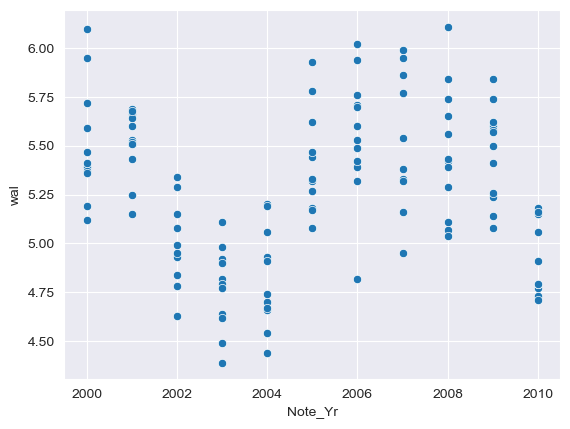

In [205]:

sns.scatterplot(data=wal_groups[wal_groups['Note_Yr']<=2010], x='Note_Yr', y='wal', legend=False)

In [215]:
prime_annual = prime_df[prime_df.columns[1:]].groupby('p_YEAR').mean()[['PRIME']].reset_index()
prime_annual = prime_annual[prime_annual['p_YEAR']>=2000]

In [226]:
prime_annual[prime_annual['p_YEAR']<=2010]
wal_groups[wal_groups['Note_Yr']<=2010]

,Note_Yr,Note_Mth,wal
0,2000,1,5.39
1,2000,2,6.10
2,2000,3,5.39
3,2000,4,5.37
4,2000,5,5.95
...,...,...,...
127,2010,8,5.06
128,2010,9,4.79
129,2010,10,4.79
130,2010,11,4.73


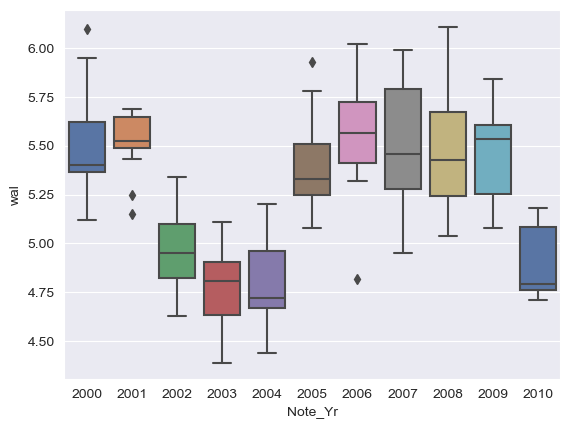

In [227]:
import matplotlib.pyplot as plt

fig_a = sns.boxplot(x='Note_Yr', y='wal', data=wal_groups[wal_groups['Note_Yr']<=2010], palette='deep')


<AxesSubplot: ylabel='PRIME'>

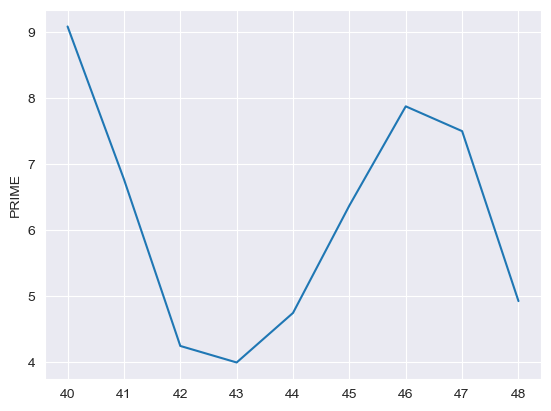

In [219]:
sns.lineplot(data=prime_annual[prime_annual['p_YEAR']<=2010]['PRIME'])

## Survivorship

In [10]:
# Group by year and month of origination
df_grouped = test_df.groupby(['Note_Yr', 'Note_Mth'])


def balance_rundown(grp):
    balance_dict = {}
    start_balance = grp['LoanAmt'].sum()
    balance_dict[0] = start_balance
    months_to_track = list(range(0, 121, 6))
    # Loop through each month and calculate balance rundown
    for month in months_to_track[1:]:
        # Remove loans with PP_Qty less than or equal to x months
        balance =round(grp.loc[(grp['PP_Qty'] > month) | (grp['PP_Qty'].isna()), 'LoanAmt'].sum(),2)
        # Add remaining balance to dictionary
        balance_dict[month] = balance
    
    return balance_dict


def loan_count(grp, date_str):
    loan_count_dict = {}
    n_loans = grp['GP'].count()
    loan_count_dict[0] = n_loans
    months_to_track = list(range(0, 252, 1))
    curr_time = dt.datetime.now()
    for month in months_to_track[1:]:
        test_date = pd.to_datetime(date_str) + np.timedelta64(month,'M')
        # conidition == FALSE if the test_date is LESS than the curr_date
        condition = test_date > curr_time
        if not condition:
        # Filter loans with PP_Qty greater than month or missing values
            outstanding_loans = grp.loc[(grp['PP_Qty'] > month) | (grp['PP_Qty'].isna())]
            # Count the number of outstanding loans
            n_outstanding_loans = outstanding_loans['GP'].count()
            # Add the number of outstanding loans to the dictionary
            loan_count_dict[month] = n_outstanding_loans
    return loan_count_dict

master_dict = {}
for name, grp in df_grouped:
    x = name
    yr = [y for y in x][0]
    mth = [y for y in x][1]

    date_str = f"{yr}-{mth}"
    master_dict[name] = loan_count(grp, date_str)
    

In [58]:
df_sample = pd.DataFrame(master_dict)
my_range = list(range(0,252,1))

# long way -- probs a way to vectorize this

data = {}
for idx, row in df_sample.transpose().iterrows():
    cohort_name = f"{idx[0]}-{idx[1]}"
    data_row = (row.to_list())
    survivorship = [round(100*(1-(data_row[0]-d)/data_row[0]), 3) for d in data_row]
    data[cohort_name] = survivorship
    


In [81]:
# pd.DataFrame(data).plot(figsize=(12,10), grid=True)
import plotly.express as px
surv = pd.DataFrame(data)

# fig = px.line(data_frame=surv, line_shape='linear')
# fig.show()
# surv.plot(figsize=(15,10), grid=True)

In [83]:
surv['mean'] = surv.mean(axis=1)
surv['stdev'] = surv.std(axis=1)
surv['+3sig']= surv['mean']+3*surv['stdev']
surv.loc[surv['+3sig']>100,'+3sig'] = 100
surv['-3sig']= surv['mean']-3*surv['stdev']
surv.loc[surv['-3sig']<0,'-3sig'] = 0

In [84]:
surv = surv.drop(columns='stdev')

In [85]:
surv[surv.columns[-3:]]

,mean,+3sig,-3sig
0,100.000000,100.000000,100.000000
1,99.957869,100.000000,99.517911
2,99.906196,100.000000,99.288724
3,99.825880,100.000000,98.989547
4,99.752259,100.000000,98.804687
...,...,...,...
247,4.967156,8.839373,1.094939
248,4.923774,8.883248,0.964301
249,4.824200,8.469687,1.178713
250,4.835586,8.186355,1.484817


In [ ]:
sns.relplot(data=surv[surv.columns[-3:]], kind='line', height=8.27, aspect=11.7/8.27)

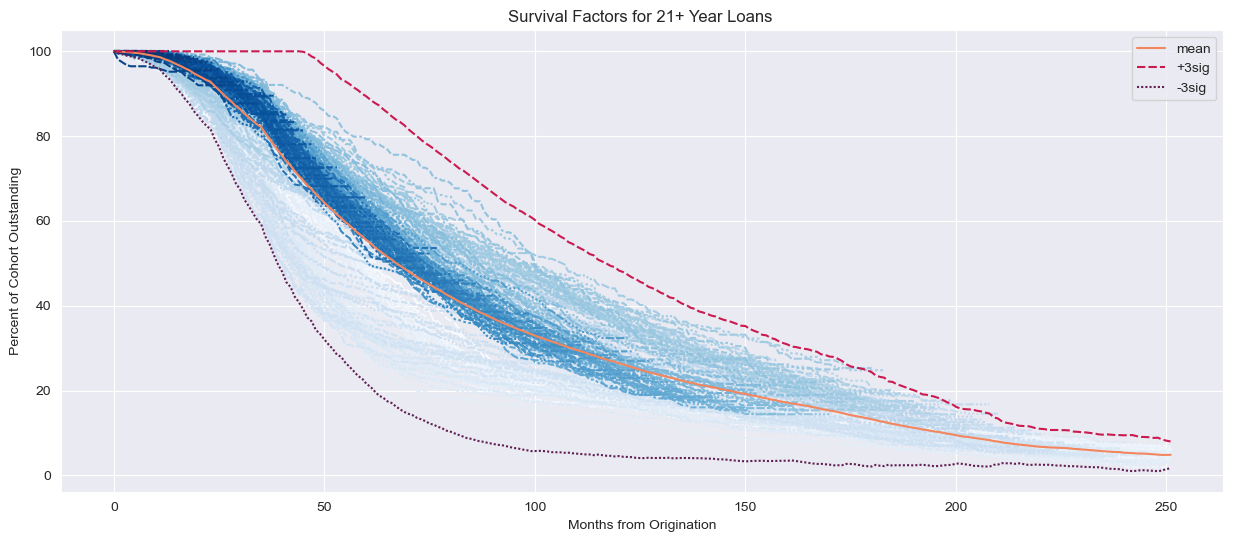

In [200]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create a single plot
fig, ax = plt.subplots(figsize=(15, 6))

sns.set_style("darkgrid")

# all cohort survivorship
fig_1 =sns.lineplot(data=surv[surv.columns[:-4]], alpha=1, ax=ax, legend=False, palette="Blues")

# Plot the line chart on the same axis
sns.lineplot(data=surv[surv.columns[-3:]], palette='rocket_r' ,ax=ax)

# sns.color_palette("Paired")
# Add titles and labels to the plot
ax.set_title("Survival Factors for 21+ Year Loans ")
ax.set_xlabel("Months from Origination")
ax.set_ylabel("Percent of Cohort Outstanding")

# Show the plot
plt.show()

In [ ]:
import seaborn as sns

fig_1 = sns.relplot(data=surv[surv.columns[:-4]], kind="scatter", alpha=.5, height=8.27, aspect=11.7/8.27)

fig_1._legend.remove()


In [146]:
pd.DataFrame(master_dict)

In [104]:
prime_df.head()

,DATE,p_YEAR,p_MONTH,PRIME
0,1955-08-04,1955,8,3.25
1,1955-10-14,1955,10,3.50
2,1956-04-13,1956,4,3.75
3,1956-08-21,1956,8,4.00
4,1957-08-06,1957,8,4.50
